# ARIMA COVID-19 Time Series Forecasting
This project basically looks at the use of:
1. ARIMA model to forecasT Nigeria COVID-19 confirmed cases

### Importing the libraries to be used

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA

In [22]:
# Load the data into a pandas DataFrame
df = pd.read_csv("C:\\Users\\oogidiagba\\Documents\\Obaro\\NCDCdata\\time_series.csv")

df = df[['Date', 'Confirmed_cases']]

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# set the index to the date column
df = df.set_index("Date")

# Resample daily data into monthly data
df_monthly = df.resample('W').sum()

# Drop any missing values in the resampled data
df_monthly = df_monthly.dropna()

In [24]:
df_monthly.head(20)

,Confirmed_cases
Date,
2020-04-05,93
2020-04-12,91
2020-04-19,304
2020-04-26,646
2020-05-03,1284
2020-05-10,1841
2020-05-17,1561
2020-05-24,1879
2020-05-31,2323


In [9]:
df_weekly.index

DatetimeIndex(['2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
               '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31',
               '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
               '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', freq='M')

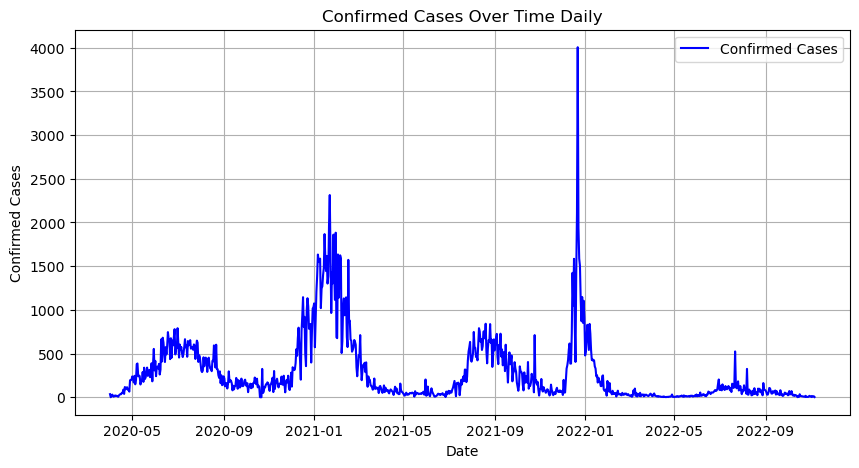

In [10]:
# Create a line chart for the 'Confirmed_cases' column
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Confirmed_cases'], label='Confirmed Cases', color='blue')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed Cases Over Time Daily')
plt.legend()
plt.grid(True)
plt.show()

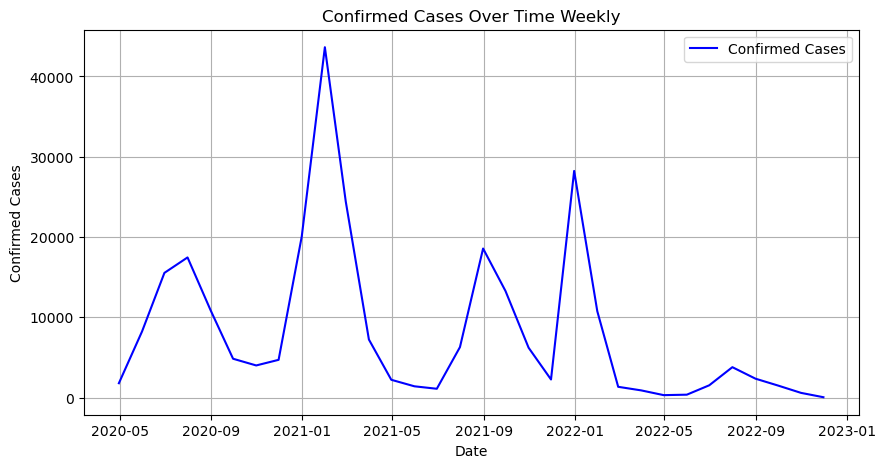

In [11]:
# Create a line chart for the 'Confirmed_cases' column
plt.figure(figsize=(10, 5))
plt.plot(df_weekly.index, df_weekly['Confirmed_cases'], label='Confirmed Cases', color='blue')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed Cases Over Time Weekly')
plt.legend()
plt.grid(True)
plt.show()

<Axes: ylabel='Count'>

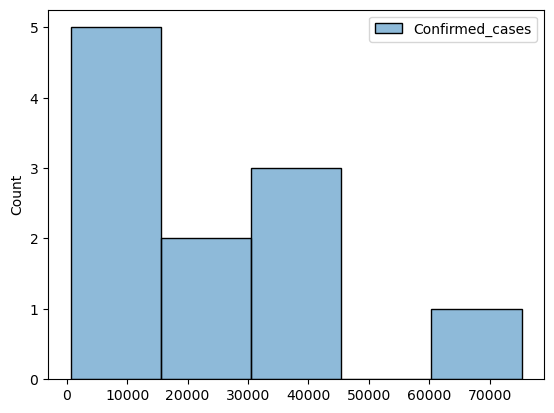

In [19]:
# Distribution of confirmed cases
sns.histplot(df_weekly[['Confirmed_cases']])

<Axes: >

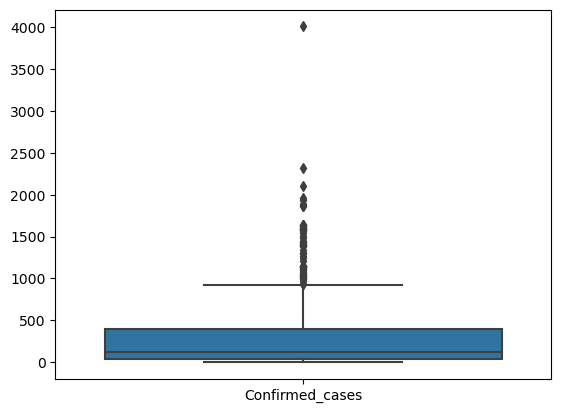

In [8]:
sns.boxplot(data=df[["Confirmed_cases"]])

<Axes: ylabel='Count'>

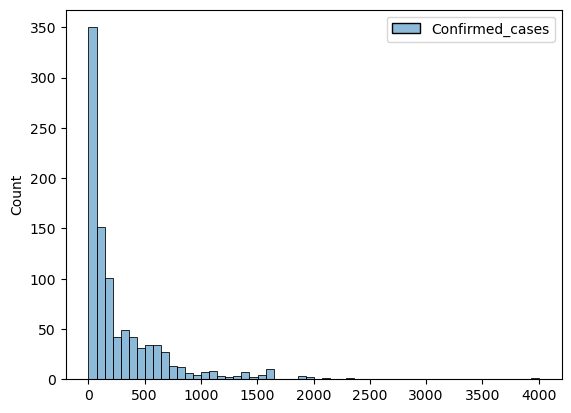

In [9]:
sns.histplot(df[['Confirmed_cases']])

<Axes: >

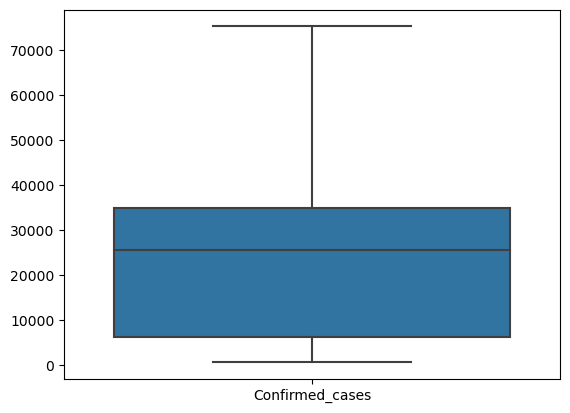

In [20]:
# Checking for outliers for confirmed cases
sns.boxplot(data=df_weekly[["Confirmed_cases"]])

# COVID-19 Time Series Forecasting Using the ARIMA Model

###### EDA: Decomposing the time series
This step is to perform some EDA on the confirmed cases data to determine if the data has some trends and to check for seasonality. To carry out an ARIMA model time series, one of the assumptions is that the data must be stationary and so decomposing the data can be helpful in visually inspecting the data.

In [21]:
def split_train_test(df, train_percentage=0.8):
    split_index = int(len(df) * train_percentage)
    df1 = df[:split_index]
    df2 = df[split_index:]
    return df1, df2

df1, df2 = split_train_test(df_weekly)

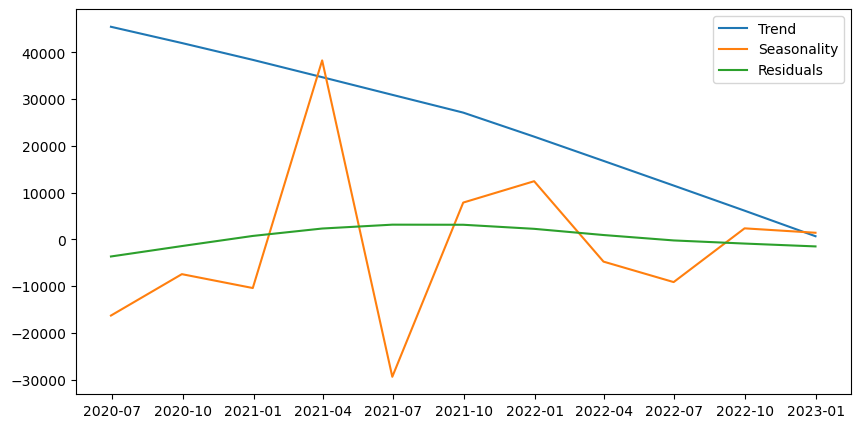

In [22]:
# Perform the decomposition using STL with seasonal=7 for weekly seasonality
stl = STL(df_weekly['Confirmed_cases'], trend=None, robust=True, seasonal=3)
result = stl.fit()

# Extract the trend, seasonality, and residuals
df_weekly['trend'] = result.trend
df_weekly['seasonality'] = result.seasonal
df_weekly['residuals'] = result.resid

# Plot the original time series data and the decomposed components
plt.figure(figsize=(10,5))
# plt.plot(df_weekly['Confirmed_cases'], label='Original')
plt.plot(df_weekly['trend'], label='Trend')
plt.plot(df_weekly['seasonality'], label='Seasonality')
plt.plot(df_weekly['residuals'], label='Residuals')
plt.legend()
plt.show()

###### ADF Test for Stationarity
The Augmented Dickey Fuller Test checks to fulffill the assumption of stationarity for time series analysis as shown below.

In [12]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
# ADF for Confirmed cases
adf_test(df_weekly['Confirmed_cases'], title='Confirmed Cases')

Augmented Dickey-Fuller Test: Confirmed Cases
ADF test statistic       -3.747464
p-value                   0.003493
# lags used               2.000000
# observations          138.000000
critical value (1%)      -3.478648
critical value (5%)      -2.882722
critical value (10%)     -2.578065
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### Autocorrelation (ACF) and Partial Autocorrelation (PACF)
To further examine the behavior of the time series and determine the order of the ARIMA model i.e., (p,d,q) we can plot the ACF and PACF of the time series.
###### ACF
An autocorrelation plot, also known as a correlogram, displays the correlation coefficients between a time series and its own lagged values. It plots the autocorrelation function (ACF) which is the correlation between the time series and lagged versions of itself.
The autocorrelation plot can help us determine if a time series is stationary or not, as well as identify the presence of seasonality or trends.
###### PACF
PACF helps to identify the direct relationship between an observation in a time series and its past observations, without being influenced by the relationship between the past observations themselves.

This articles shows to interpret ACF and PACF https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali/

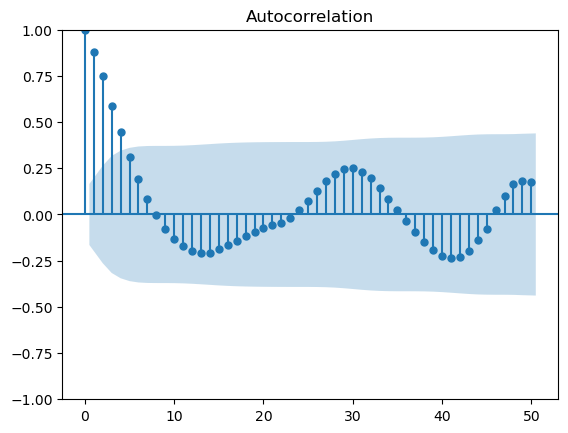

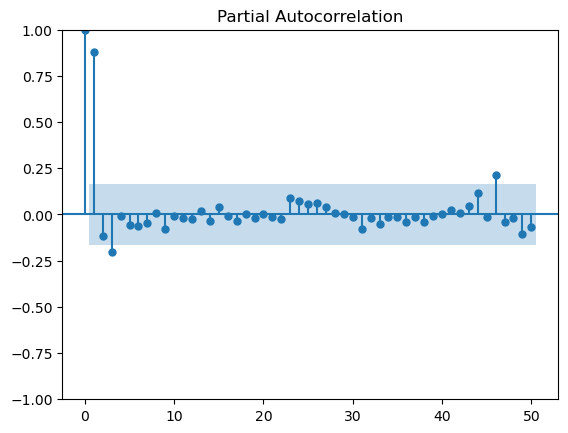

In [14]:
# create a new figure and plot the ACF
fig = sgt.plot_acf(df_weekly['Confirmed_cases'].values, lags=50)

# create another figure and plot the PACF
fig = sgt.plot_pacf(df_weekly['Confirmed_cases'].values, lags=50)


From the ACF plot above, it is difficult to tell if the data has any identifiable trends and doesn,t show any seasonality. We can see that as the lags increases it tails off gradually and does not get to zero. This could mean that the data exhibis random walk time series behaviour  where the difference between consecutive observations is a white noise process. This means that the series has no trend, and each observation is an unpredictable variation around the previous observation. Hence, the ARIMA model may not produce the best forecast for the time series

##### Building the ARIMA model
We can use the auto_arima method in python to automatically determeine the optimal oder of AR (p), the differencing (d) and MA (q) required to build the model. We can use the AIC to choose the best model.

We had to aggregate the data weekly using the resample method in python as this smoothen the time series, hopefully leading to better forecasting and data fit.

In [15]:
from pmdarima.arima import auto_arima

# Fit auto_arima model on the resampled data
stepwise_model = auto_arima(df1['Confirmed_cases'], seasonal=False, suppress_warnings=True, trace=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1931.562, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2146.239, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1929.636, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2051.789, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1930.661, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1930.991, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1933.293, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1928.559, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2085.017, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1928.773, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1929.379, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2005.953, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1932.392, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.503 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  112
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -961.280
Date:                Wed, 20 Sep 2023   AIC                           1928.559
Time:                        16:49:25   BIC                           1936.715
Sample:                    03-01-2020   HQIC                          1931.868
                         - 04-17-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    295.9000    282.519      1.047      0.295    -257.827     849.627
ar.L1          0.8640      0.034     25.381      0.000       0.797       0.931
sigma2      1.652e+06   9.16e+04     18.033      0.000    1.47e+06    1.83e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):              1376.73
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):              14.36   Skew:                             1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Interpreting the Results of the fitted ARIMA models

This is a summary of a SARIMAX model that has been fitted to a time series of the dependent variable 'y.' The model employed is a seasonal autoregressive integrated moving average model with exogenous variables.

The model specifications include three autoregressive terms (AR1, AR2, AR3), no differencing (indicating stationarity), and one moving average term (MA1). Let's delve into the coefficient estimates and their significance:

The intercept term has a positive estimate, and while it is statistically significant at the 5% level, it falls marginally short of significance at the stricter 1% level.

The first autoregressive coefficient (AR1) is positive and highly statistically significant (p-value < 0.001), suggesting a strong positive relationship between the current value of 'y' and its own previous value. This indicates a persistent positive effect.

The second autoregressive coefficient (AR2) is negative but not statistically significant (p-value > 0.05). This implies that 'y' may not have a significant relationship with its own values from two time periods ago.

The third autoregressive coefficient (AR3) is negative and statistically significant (p-value < 0.05), indicating a negative relationship between the current 'y' value and its value from three time periods ago. This suggests a short-term negative influence.

The moving average coefficient (MA1) is negative and highly statistically significant (p-value < 0.01), signifying that the current 'y' value is negatively influenced by the residual from the previous time point.

Additionally, the model diagnostics are as follows:

The Ljung-Box test, with a p-value of 0.80, indicates that there is no evidence of autocorrelation in the residuals up to lag 1. This suggests that the model captures most of the temporal dependence in the data.

The Jarque-Bera test, with a p-value of 0.00, suggests that the residuals are not normally distributed. This indicates that the model may not fully capture all the information in the data, and there may be some unmodeled patterns.

The Heteroskedasticity test, with a p-value of 0.45, suggests that the variance of the error term is relatively constant over time, which is a positive sign for the model's stability.

The skewness and kurtosis values of the residuals indicate that the distribution of residuals is roughly symmetric, but it has slightly heavier tails than a normal distribution, implying that there might be some occasional outliers or fat-tailed behavior in the data.

In summary, this SARIMAX model provides a useful framework for making predictions about the dependent variable 'y.' However, it's important to note that it may not capture all the complexities in the data, especially considering the non-normality of the residuals and the marginally insignificant intercept. Further model refinement or exploration of other factors may be necessary for a more accurate representation of the underlying processes.

In [22]:
order = (1, 0, 0)
model = ARIMA(df1['Confirmed_cases'], order=order)
results = model.fit()

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Confirmed_cases   No. Observations:                  112
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -961.298
Date:                Wed, 20 Sep 2023   AIC                           1928.595
Time:                        16:50:42   BIC                           1936.751
Sample:                    03-01-2020   HQIC                          1931.904
                         - 04-17-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2282.7499   1637.889      1.394      0.163    -927.454    5492.953
ar.L1          0.8699      0.034     25.699      0.000       0.804       0.936
sigma2      1.652e+06   9.14e+04     18.083      0.000    1.47e+06    1.83e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.48   Jarque-Bera (JB):              1378.34
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):              14.34   Skew:                             1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

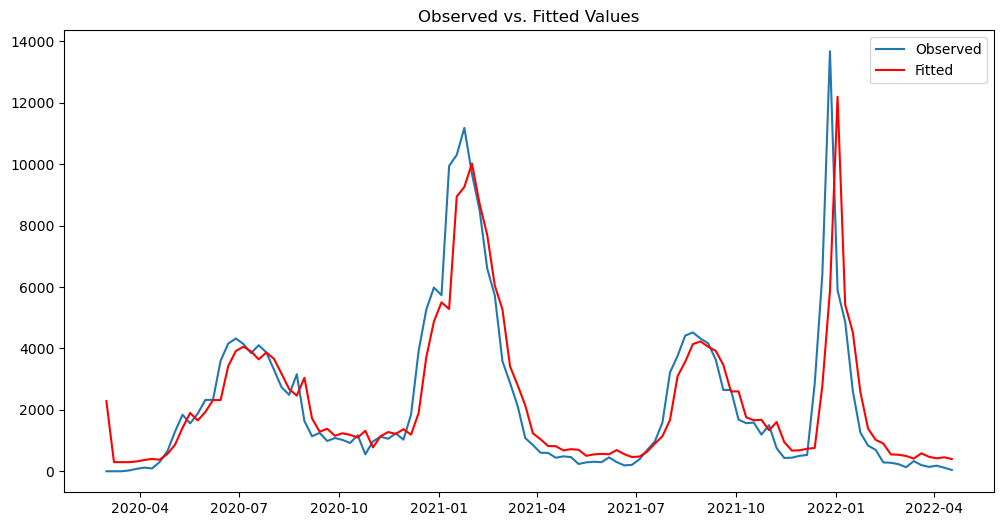

In [24]:
# Plot the observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(df1['Confirmed_cases'], label='Observed')
plt.plot(results.fittedvalues, label='Fitted', color='red')
plt.legend()
plt.title('Observed vs. Fitted Values')
plt.show()

In [25]:
len(df2)

29

In [28]:
# Assuming you want to forecast the next 30 periods
forecast_periods = 29

# Make predictions/forecasts
start_index = len(df1)
end_index = len(df1) + forecast_periods - 1

# Create a DataFrame for predictions
forecasted_data = results.predict(start=start_index, end=end_index, dynamic=False)
forecasted_df = pd.DataFrame({'predicted': forecasted_data}, index=df2.index[start_index:end_index + 1])

# Merge the predictions with df2
df2 = pd.concat([df2, forecasted_df], axis=1)


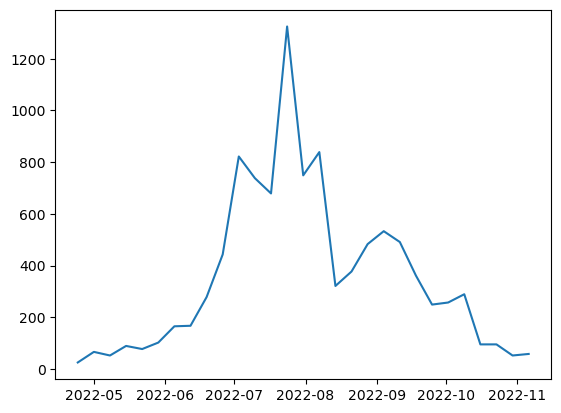

In [29]:
import matplotlib.pyplot as plt
plt.plot(df2[['Confirmed_cases', 'predicted']])

###### Evaluating the fitted ARIMA model using the plot_diagnostics() function
The plots generated by this method include:

1. A histogram plot of the residuals: This plot shows the distribution of the residuals and can help you determine whether they are normally distributed. Ideally, the residuals should be normally distributed, which would show up as a bell-shaped curve on the histogram plot.

2. A kernel density plot of the residuals: This plot is similar to the histogram plot, but instead of using discrete bins, it shows a continuous density estimate of the distribution of the residuals.

3. A QQ plot of the residuals: This plot compares the distribution of the residuals to a normal distribution. If the residuals are normally distributed, they should lie along a straight line on the QQ plot.

4. A correlogram or autocorrelation plot of the residuals: This plot shows the correlation between the residuals at different lags. Ideally, there should be no significant correlation between the residuals at any lag.

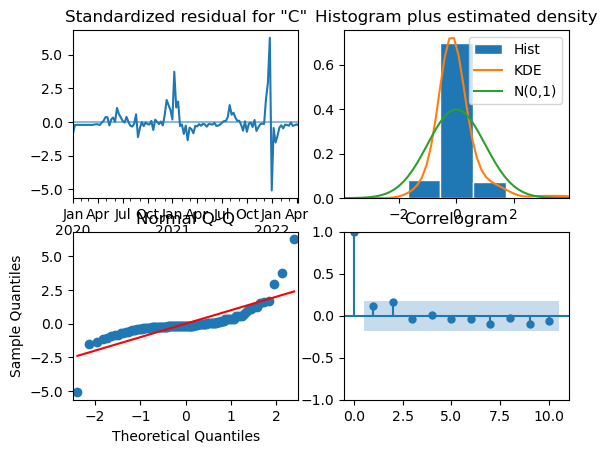

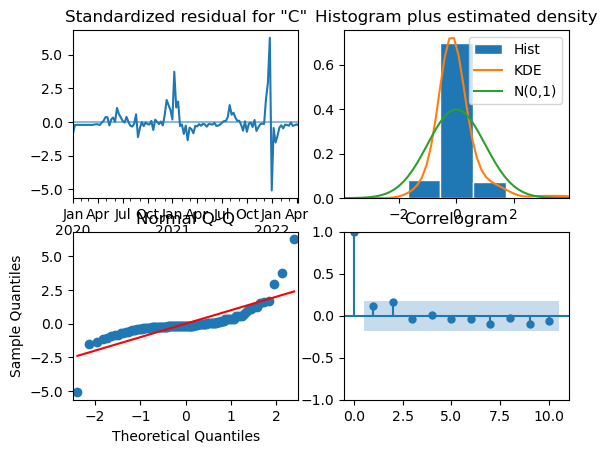

In [28]:
results.plot_diagnostics()

Mean Absolute Error (MAE): 645.39


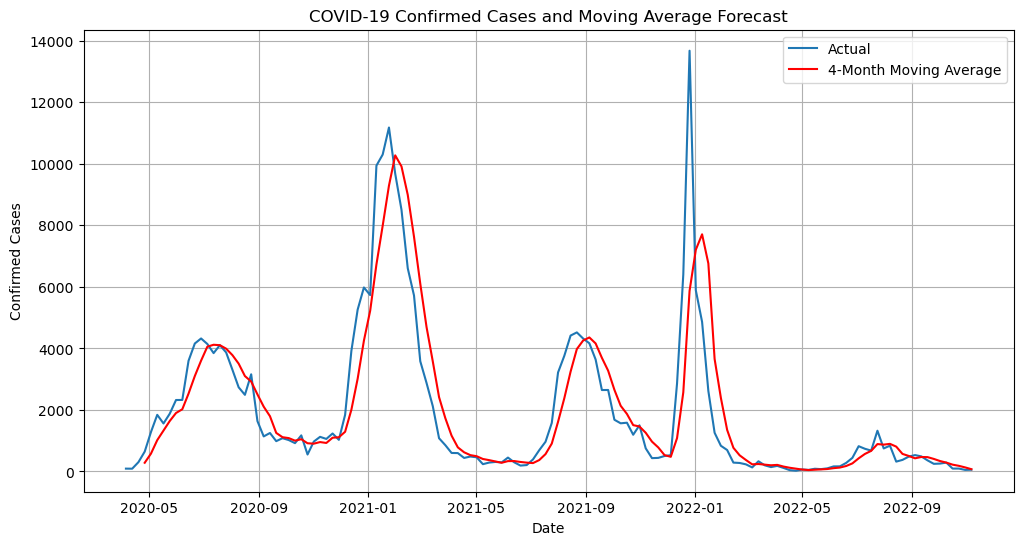

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
df = pd.read_csv("C:\\Users\\oogidiagba\\Documents\\Obaro\\NCDCdata\\time_series.csv")

# Select and rename relevant columns
df = df[['Date', 'Confirmed_cases']]
df.columns = ['Date', 'Confirmed Cases']

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the index to the date column
df.set_index("Date", inplace=True)

# Resample daily data into monthly data
df_monthly = df.resample('W').sum()

# Drop any missing values in the resampled data
df_monthly = df_monthly.dropna()

# Calculate the moving average for forecasting (e.g., 3-month moving average)
window = 4
df_monthly['Moving Average'] = df_monthly['Confirmed Cases'].rolling(window=window).mean()

# Plot the original data and the moving average forecast
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Confirmed Cases'], label='Actual')
plt.plot(df_monthly.index, df_monthly['Moving Average'], label=f'{window}-Month Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Confirmed Cases and Moving Average Forecast')
plt.legend()
plt.grid(True)

# Calculate and print the Mean Absolute Error (MAE) to assess forecast accuracy
mae = np.mean(np.abs(df_monthly['Confirmed Cases'] - df_monthly['Moving Average']))
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Show the plot
plt.show()

In [18]:
import pandas as pd
import numpy as np

# Load your data into a pandas DataFrame
df = pd.read_csv("C:\\Users\\oogidiagba\\Documents\\Obaro\\NCDCdata\\time_series.csv")

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Resample daily data into monthly data
df_monthly = df.resample('M').sum()

# Drop any missing values in the resampled data
df_monthly = df_monthly.dropna()

# Calculate the moving average forecast (e.g., for a 3-month moving average)
window_size = 3  # You can adjust this window size
df_monthly['Moving_Average_Forecast'] = df_monthly['Confirmed_cases'].rolling(window=window_size).mean()

# Drop rows with NaN values (due to the rolling window)
df_monthly = df_monthly.dropna()

# Actual values
actual_values = df_monthly['Confirmed_cases'].values

# Forecasted values (moving average)
forecasted_values = df_monthly['Moving_Average_Forecast'].values

# Calculate the squared differences between actual and forecasted values
squared_errors = (actual_values - forecasted_values) ** 2

# Calculate the mean squared error (MSE)
mse = np.mean(squared_errors)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE) for {window_size}-Month Moving Average Forecast: {rmse}")


Root Mean Squared Error (RMSE) for 3-Month Moving Average Forecast: 7535.968270260323


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Load the data into a pandas DataFrame
df = pd.read_csv("C:\\Users\\oogidiagba\\Documents\\Obaro\\NCDCdata\\time_series.csv")

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Resample daily data into monthly data
df_monthly = df['Confirmed_cases'].resample('M').sum()

# Check if the df_monthly DataFrame has a column named 'Confirmed_cases'
if 'Confirmed_cases' not in df_monthly.columns:
    df_monthly['Confirmed_cases'] = 0

# Drop any missing values in the resampled data
df_monthly = df_monthly.dropna()

# Perform Exponential Smoothing
alpha = 0.2  # Smoothing parameter (adjust as needed)
model = SimpleExpSmoothing(df_monthly.values)
fit = model.fit()

# Forecast the next 3 months (adjust the number as needed)
forecast_steps = 3
forecast = fit.forecast(steps=forecast_steps)

# Create a Pandas DatetimeIndex object for the forecast dates
forecast_dates = pd.date_range(start=df_monthly.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_dates)

# Combine the original data and the forecast
combined_df = pd.concat([df_monthly, forecast_df])

# Check if the combined_df DataFrame has a column named 'Confirmed_cases'
if 'Confirmed_cases' not in combined_df.columns:
    raise KeyError('The column "Confirmed_cases" does not exist in the DataFrame.')

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Confirmed_cases'], label='Observed', marker='o')
plt.plot(combined_df.index, combined_df['Forecast'], label='Forecast', linestyle='--', marker='o')
plt.legend()
plt.title('Monthly Confirmed Cases with Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.grid(True)
plt.show()



AttributeError: 'Series' object has no attribute 'columns'

In [40]:
combined_df.head()

,0,Forecast
2020-04-30,1791.0,NaN
2020-05-31,8231.0,NaN
2020-06-30,15533.0,NaN
2020-07-31,17457.0,NaN
2020-08-31,10857.0,NaN


In [35]:
# Combine the original data and the forecast with the correct column name
combined_df = pd.concat([df_monthly, forecast_df.rename(columns={'Forecast': '0'})])

KeyError: '0'

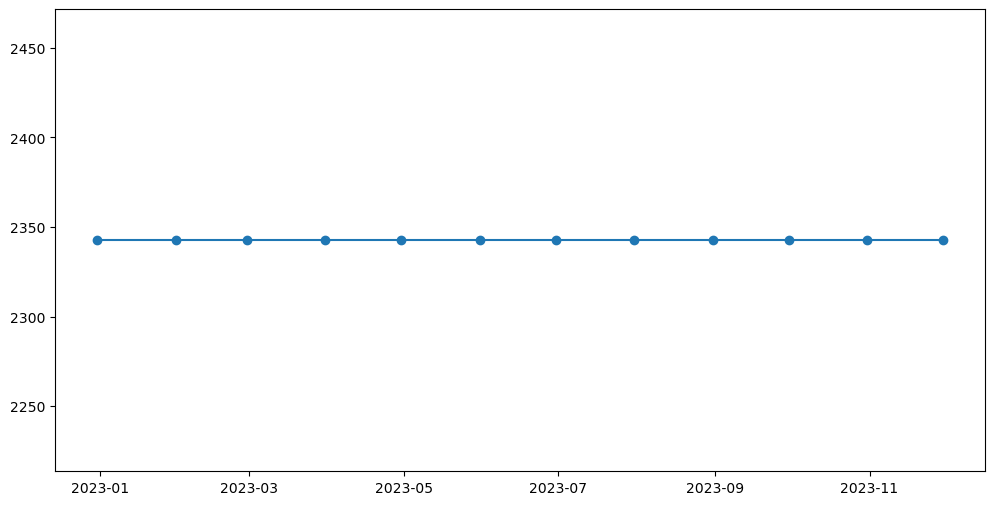

In [41]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Forecast'], label='Observed', marker='o')
plt.plot(combined_df.index, combined_df['0'], label='Forecast', linestyle='--', marker='o')
plt.legend()
plt.title('Monthly Confirmed Cases with Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.grid(True)
plt.show()
